# Equity Market Crisis Regime Prediction using Machine Learning GBDT

## Part III: Exploratory data analysis

### Quick access to the whole series:

1. [Part I: Introduction](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt1)
1. [Part II: Data Preparation](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt2)
1. [Part III: Exploratory data analysis](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt3)
1. [Part IV: Feature Selection, Hyperparameter Tuning (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt4)
1. [Part V: Model Evaluation and Interpretation (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt5)
1. [Part VI: SVM and Neural Networks (MLP and 1D-CNN)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt6)
1. [Part VII: Compare GBDT Models: XGBoost and LightGBM](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt7)
1. [Part VIII: Deployment: end-to-end process (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt8)

---




### Outline of this notebook

<a id="toc"></a>

[1. Load data](#1)

[2. Target Analysis](#2)

[3. Input Features - Equity Indexes](#3)

[4. Input Features - Economic Data](#4)

[5. Input Features - Engineered Features](#5)

[6. Input Features Correlation Matrix](#6)

## Load and install packages

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import copy
import json
from pathlib import Path
from datetime import datetime, timedelta, date
import time
from dateutil.relativedelta import relativedelta 


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import statsmodels.api as sm
import seaborn as sns


import pyarrow.parquet as pq
import pyarrow as pa

from tqdm import tqdm

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1
pl.seed_everything(random_seed)

1

In [3]:
def lines(data, figsize=(15, 8), caption='', labels=[]):
    plt.figure(figsize=figsize, dpi=100)
    colors = ['lightseagreen', 'salmon', 'lightskyblue', 'mediumseagreen', 'sandybrown', 'lightslategray', 'wheat', 'crimson']
    mcolors = ['teal', 'tomato', 'skyblue', 'mediumseagreen', 'peru', 'slategray', 'tan',  'firebrick']
    
    for i in range(data.shape[1]):
        plt.plot(data.index, data.iloc[:, i], marker='', markerfacecolor=mcolors[i], markersize=2, color=colors[i], linewidth=2, label=labels[i])
        #plt.text(data.iloc[:, i].dropna().size + 1, data.iloc[:, i].dropna().values[-1], labels[i], fontsize=11, color=mcolors[i])

    plt.legend(labels, loc='upper right')
    plt.title(caption,  fontsize=14, loc='left')

    plt.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='-', linewidth=0.2)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['bottom', 'left']].set_edgecolor('whitesmoke')
    
    plt.yticks(fontsize=9, )#rotation=90
    plt.xticks(fontsize=9, )#rotation=90
    plt.tight_layout()
    plt.show()
    
def _2lines(data, figsize=(15, 8), caption='', labels=[]):
    #['teal', 'lightseagreen', 'powderblue', 'lightcyan',  'azure','darkslategray']
    fig, ax = plt.subplots(figsize = figsize)
    ax2 = ax.twinx()
    ax.set_title(caption, fontsize=15, loc='left')
    #ax.set_xlabel('time')

    ax.plot(data.index, data.iloc[:, 0], marker='', markerfacecolor='teal', markersize=2, color='lightseagreen', linewidth=2)
    ax2.plot(data.index, data.iloc[:, 1], marker='', markerfacecolor='tomato', color='salmon', linewidth=2, )#linestyle='--'

    ax.set_ylabel(labels[0])
    ax2.set_ylabel(labels[1])
    ax.legend([labels[0]], loc='upper left')
    ax2.legend([labels[1]], loc='upper center')
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    
    ax.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='-', linewidth=0.2)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['bottom', 'left']].set_edgecolor('whitesmoke')
    ax2.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='-', linewidth=0.2)
    ax2.spines[['top', 'right']].set_visible(False)
    ax2.spines[['bottom', 'left']].set_edgecolor('whitesmoke')
    
    plt.tight_layout()

    plt.show()    

In [4]:
def bar(data, caption, figsize=(12, 6)):
    if data.index.dtype in ['int64', 'int32', 'float64', 'float32']:
        data.index = data.index.astype(str)
    
    plt.figure(figsize=figsize)
    plt.style.use('seaborn-whitegrid')
    plt.barh(data.index.values, data.values, color="lightseagreen", alpha=0.7)
    for i, v in enumerate(data.values):
        plt.text(v + 0, i + .025, f'{v:.2f}', fontsize=10, color="teal", fontweight='bold')#deepskyblue#dodgerblue
    plt.title(caption, fontsize=13, loc='left')
    #plt.xlabel(data.name, fontsize=13)
    plt.xticks([])
    plt.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='-', linewidth=0.2)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['bottom', 'left']].set_edgecolor('whitesmoke')
    plt.rc('ytick', labelsize=10, ) 
    
    plt.show()

In [5]:
def plot_corr(data, figsize=(12, 4), caption='', x_bottom=True):   
    mask = np.zeros_like(data, dtype=bool)
    mask = np.triu(np.ones_like(data, dtype=bool)) #uncomment if only show under the diagnoal line

    vmax = np.round(np.nanmax(data.where(~mask)) - 0.05, 2)
    vmin = np.round(np.nanmin(data.where(~mask)) + 0.05, 2)
    
    plt.figure(figsize=figsize, dpi= 80)
    
    # Specify kwargs for the heatmap
    kwargs = {
        "mask": mask,
        "cmap": "BrBG",
        "annot": False,
        "vmax": vmax,
        "vmin": vmin,
        "linewidths": 0.5,
        "annot_kws": {"size": 10},
        "cbar":False, 
        #"cbar_kws": {"shrink": 0.95, "aspect": 30},
    }

    # Draw heatmap with mask and default settings
    sns.heatmap(data, center=0, fmt=".0f", **kwargs)
    #sns.heatmap(data, xticklabels=cs.columns, yticklabels=cs.index, cmap='RdYlGn', center=0, annot=True,  cbar=False, fmt='.0f')#YlGnBu#RdYlGn

    #ax.set_title(f"Feature-correlation", fontdict={"fontsize": 18})

    if not x_bottom:
        plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    plt.title(caption, fontsize=15, loc='left')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

<a id="1"></a>

# <left>1. Load data</left>

[back to top](#toc)

In [6]:
df = pd.read_parquet('../input/equity-market-crisis-regime-prediction-using-gbdt2/data.parquet')
df.set_index(keys=['x_date'], inplace=True)

In [7]:
target_cols = ['pct_chg15', 'regime_change', 'target']
feats = list(set(df.columns)-set(target_cols))
len(feats)

3776

In [8]:
df.sort_index(ascending=True, inplace=True)

In [9]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [10]:
train_start, train_end =  '2004-01-01',  '2019-12-01'
test_sart, test_end = '2020-01-01', '2022-09-10'

In [11]:
train_df = df[(df.index>=train_start) & (df.index<=train_end)]
test_df = df[(df.index>=test_sart) & (df.index<=test_end)]

train_df.shape,  test_df.shape

((4006, 3779), (708, 3779))

<a id="2"></a>

# <left>2. Target Analysis</left>

[back to top](#toc)

## Label (Positive Label - Crisis Regime; Negative Label - Normal Regime) Distribution

- In Training data (data before 2020): 96% are Negative Label; Negative/Postive ratio is 24
- In whole data set (all including 2020-Sep 2022): 93% are Nagative Label; Negative/Positive ratio is 13

In [12]:
train_df['target'].value_counts()

0.00    3826
1.00     180
Name: target, dtype: int64

In [13]:
train_df['target'].value_counts()/train_df.shape[0]

0.00   0.96
1.00   0.04
Name: target, dtype: float64

In [14]:
df['target'].value_counts()/df.shape[0]

0.00   0.93
1.00   0.07
Name: target, dtype: float64

## 15-day Percentage Change and Regimes 

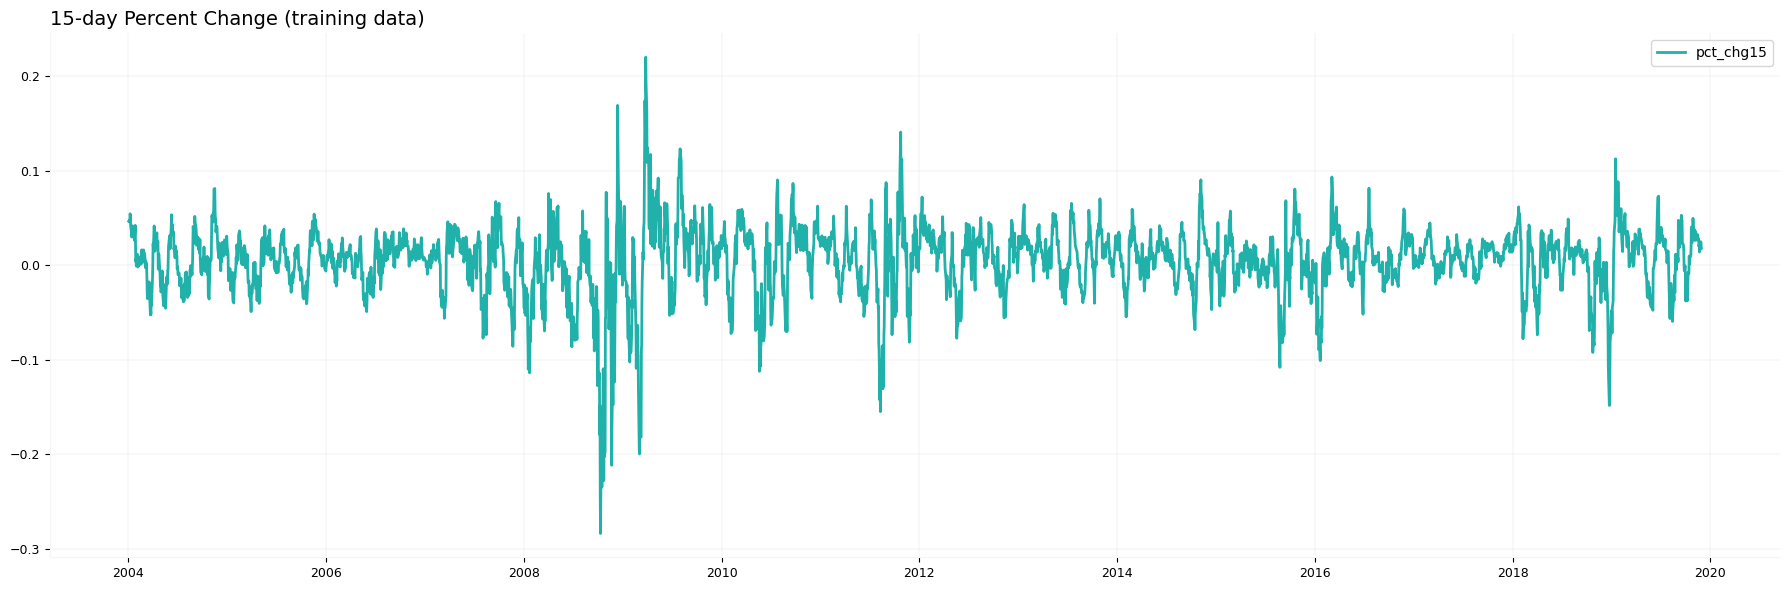

In [15]:
lines(train_df[['pct_chg15']], figsize=(18, 6), caption='15-day Percent Change (training data)', labels=['pct_chg15'])

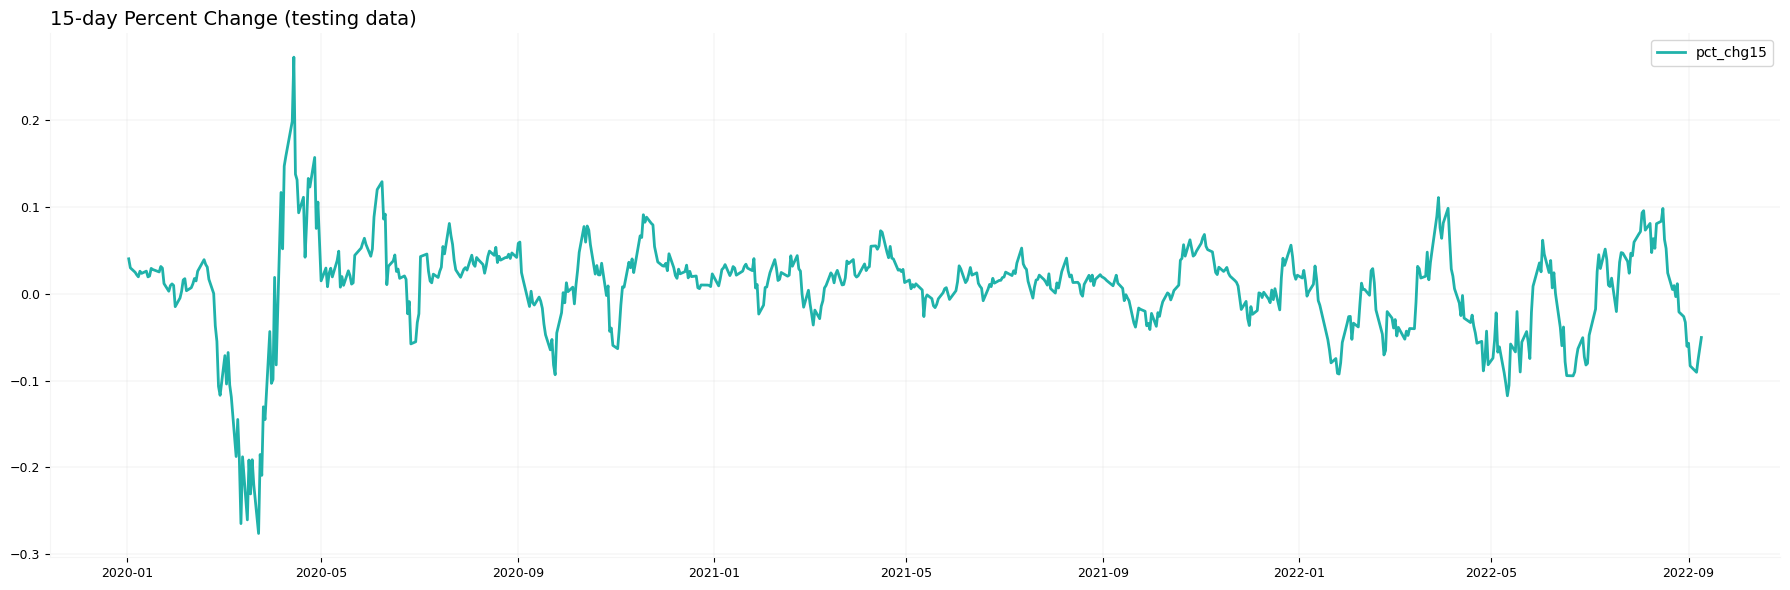

In [16]:
lines(test_df[['pct_chg15']], figsize=(18, 6), caption='15-day Percent Change (testing data)', labels=['pct_chg15'])

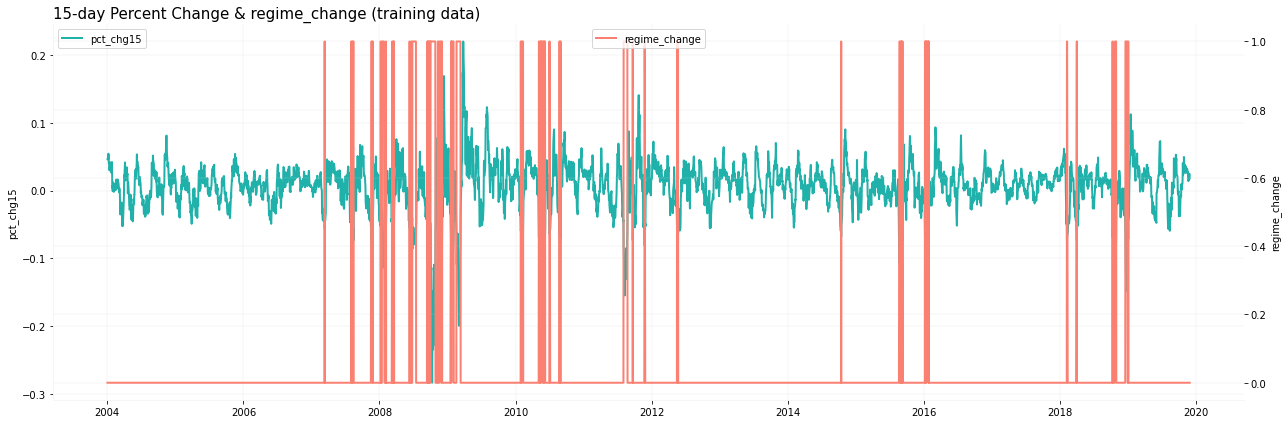

In [17]:
_2lines(train_df[['pct_chg15', 'regime_change']], figsize=(18, 6), caption='15-day Percent Change & regime_change (training data)', 
        labels=['pct_chg15', 'regime_change'])

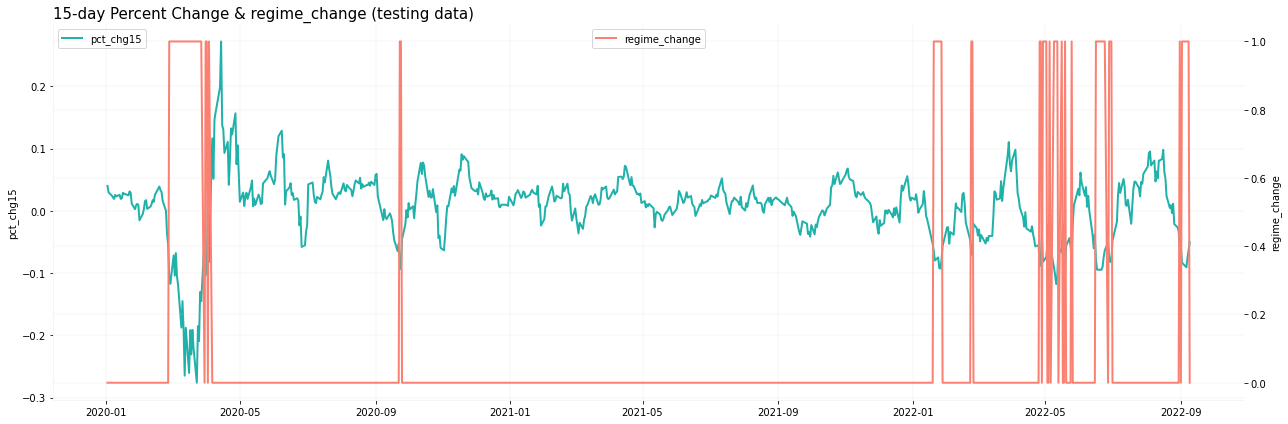

In [18]:
_2lines(test_df[['pct_chg15', 'regime_change']], figsize=(18, 6), caption='15-day Percent Change & regime_change (testing data)', 
        labels=['pct_chg15', 'regime_change'])

## Correlation to Target (training data)

In [19]:
y_corr = train_df[feats+['target']].corr()['target']

In [20]:
y_corr.name='corr'
df_corr = y_corr.to_frame()
df_corr['abs_corr'] = df_corr['corr'].abs()
df_corr.sort_values(by='abs_corr', ascending=False, inplace=True)

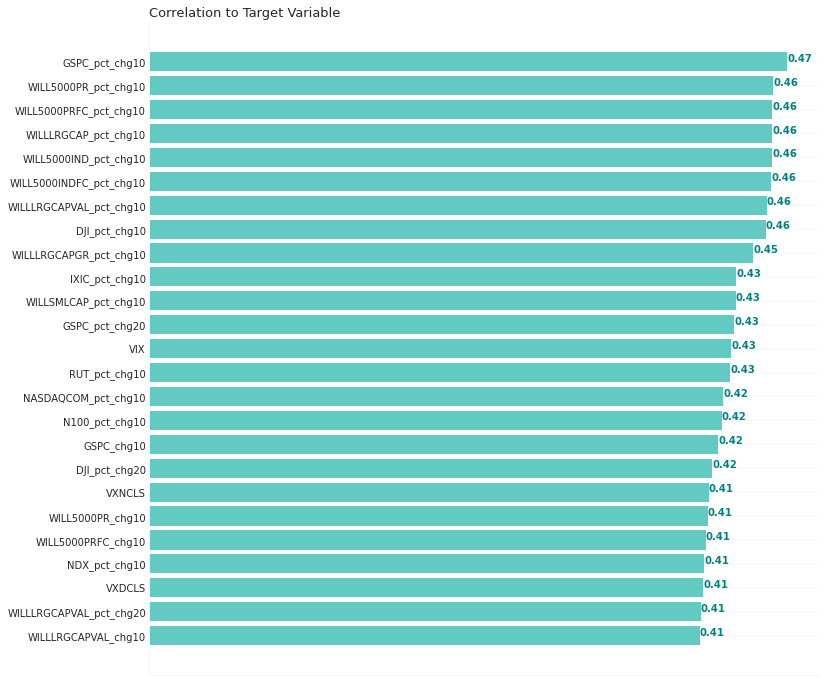

In [21]:
bar(df_corr['abs_corr'].iloc[1:26][::-1], 'Correlation to Target Variable', figsize=(12, 12))

<a id="3"></a>

# <left>3. Input Features - Equity Indexes</left>

[back to top](#toc)

|ticker|description|
|---|---|
|^GSPC |S&P 500 |
|^DJI |Dow Jones Industrial Average |
|^IXIC |NASDAQ Composite |
|^RUT |Russell 2000 |
|^VIX |CBOE Volatility Index |
|^TYX |Treasury Yield 30 Years |
|^TNX |CBOE Interest Rate 10 Year T No |
|^FVX |Treasury Yield 5 Years| 
|^IRX |13 WEEK TREASURY BILL |
|^NDX |NASDAQ 100 |
|DX-Y.NYB |US Dollar/USDX - Index - Cash |
|EEM |iShares MSCI Emerging Index Fun |
|IEMG |iShares Core MSCI Emerging Mark |
|^FTSE| FTSE 100 |
|^STOXX50E |ESTX 50 PR.EUR |
|^N225 |Nikkei 225 |
|JPY=X |USD/JPY |
|^KS11| KOSPI Composite Index |
|GC=F |Gold Dec 22 |
|CL=F |Crude Oil Nov 22 |
|^HSI |HANG SENG INDEX |
|^KLSE |FTSE Bursa Malaysia KLCI |
|^N100 |Euronext 100 Index |

In [22]:
benchmark_tickers = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^VIX', 
                     '^TYX', '^TNX','^FVX', '^IRX','^NDX', 'DX-Y.NYB',  'EEM','IEMG','^FTSE','^STOXX50E',
                     '^N225', 'JPY=X', '^KS11', 'GC=F', 'CL=F', '^HSI', '^KLSE', '^N100'
                    ]#'^SPX'

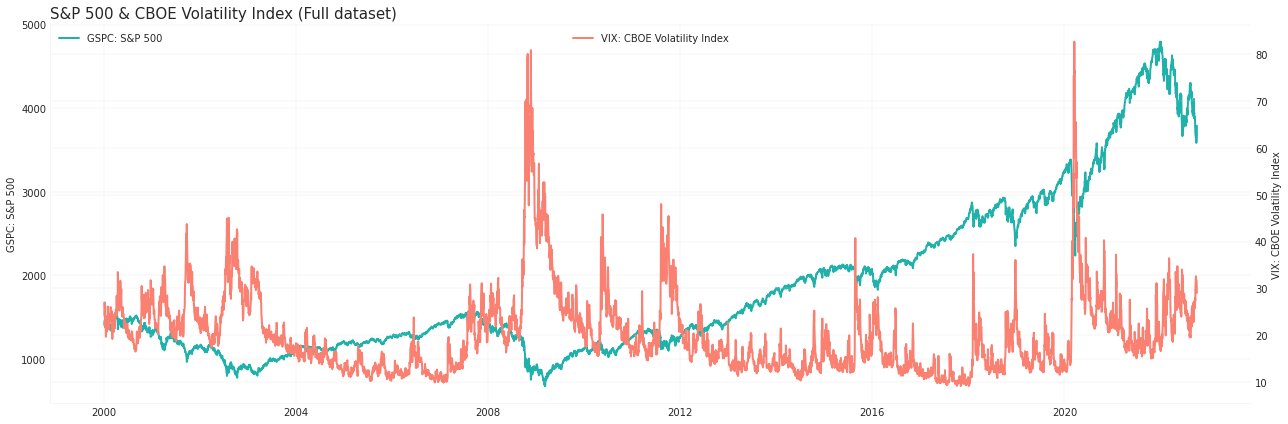

In [23]:
_2lines(df[['GSPC', 'VIX']], figsize=(18, 6), caption='S&P 500 & CBOE Volatility Index (Full dataset)', 
        labels=['GSPC: S&P 500', 'VIX: CBOE Volatility Index'])

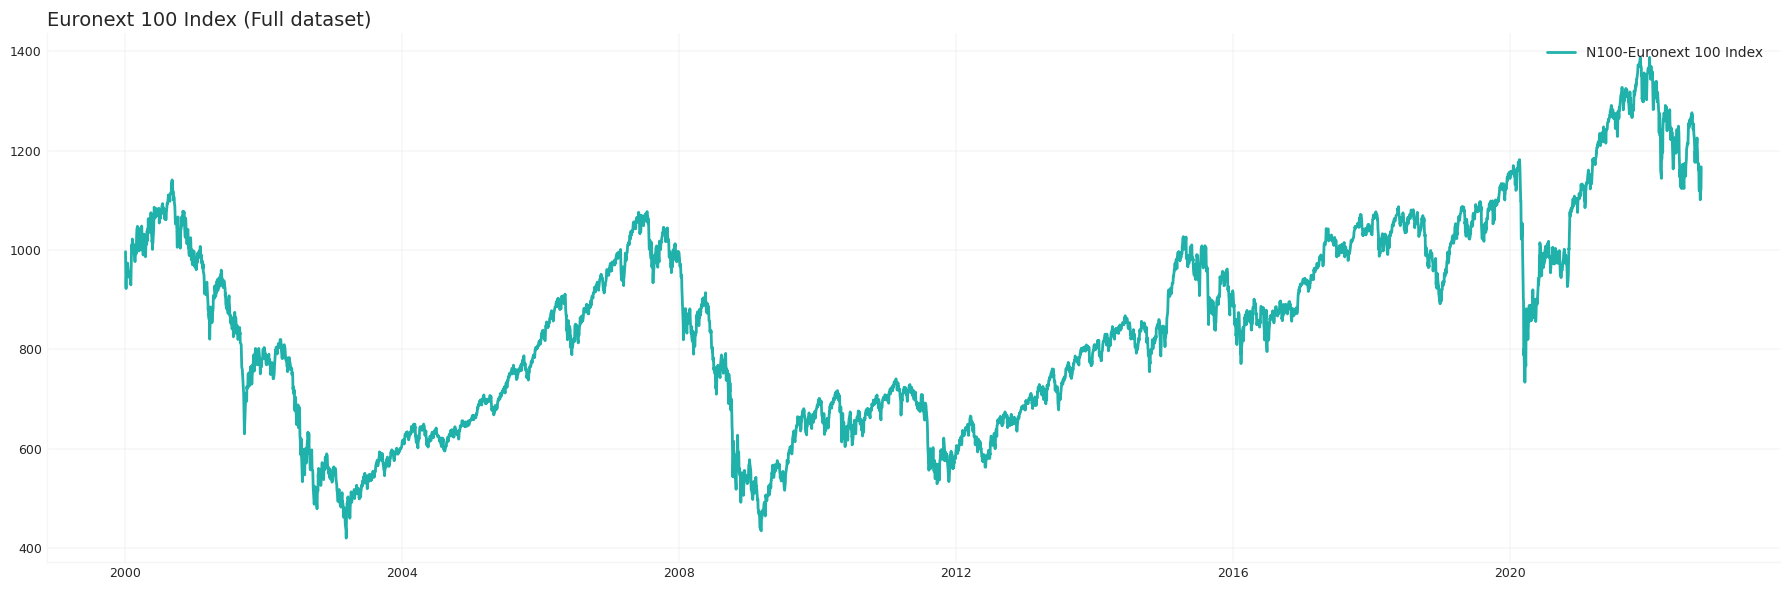

In [24]:
lines(df[['N100']], figsize=(18, 6), caption='Euronext 100 Index (Full dataset)', labels=['N100-Euronext 100 Index '])

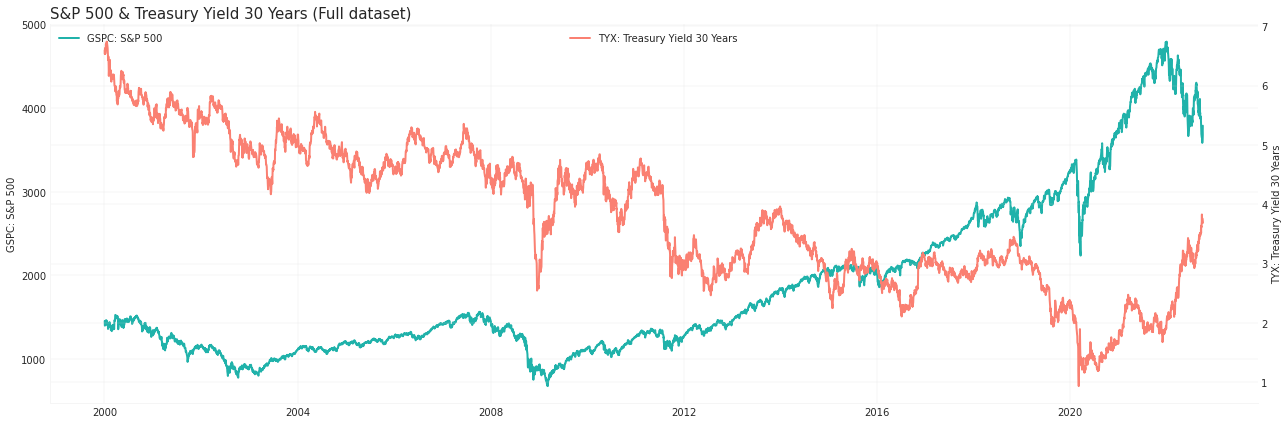

In [25]:
_2lines(df[['GSPC', 'TYX']], figsize=(18, 6), caption='S&P 500 & Treasury Yield 30 Years (Full dataset)', 
        labels=['GSPC: S&P 500', 'TYX: Treasury Yield 30 Years'])

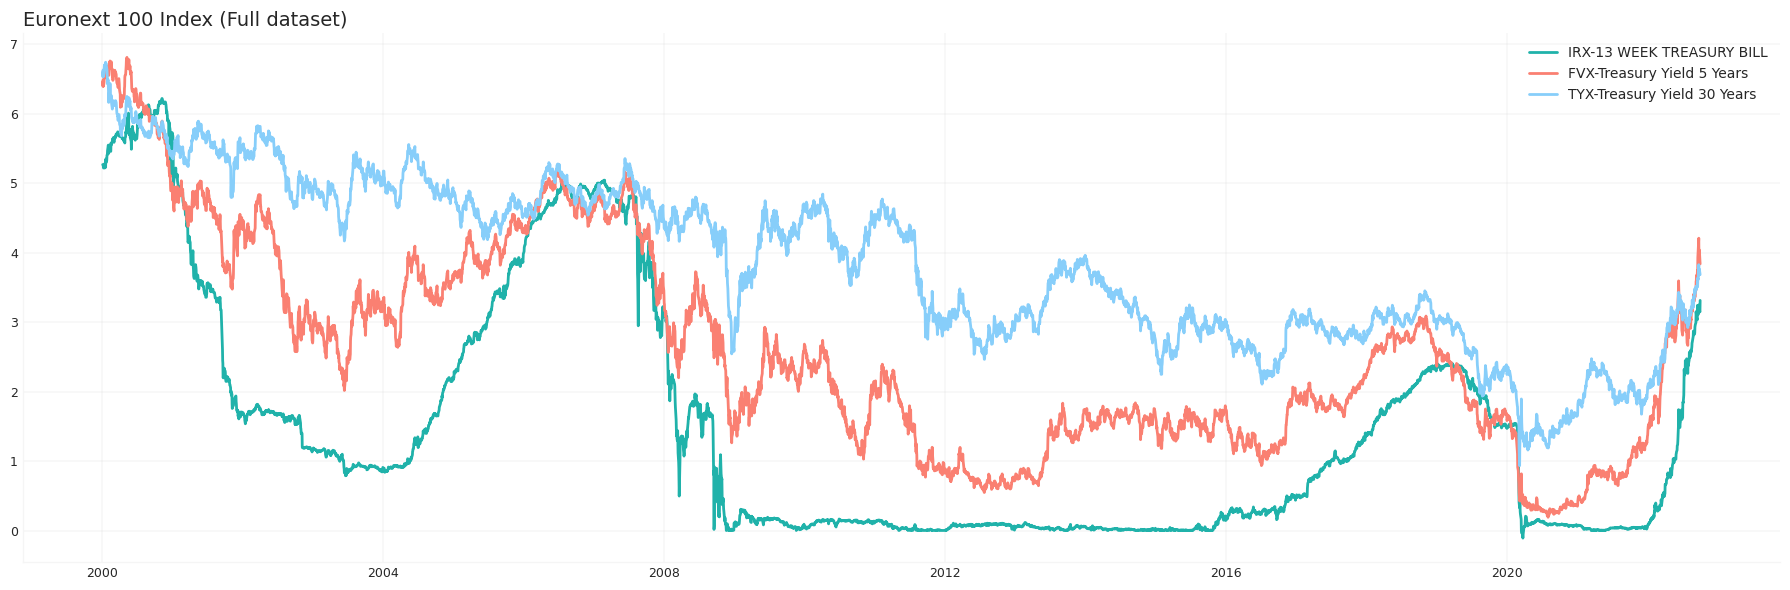

In [26]:
lines(df[['IRX', 'FVX', 'TYX']], figsize=(18, 6), caption='Euronext 100 Index (Full dataset)', 
      labels=['IRX-13 WEEK TREASURY BILL', 'FVX-Treasury Yield 5 Years', 'TYX-Treasury Yield 30 Years'])

<a id="4"></a>

# <left>4. Input Features - Economic Data</left>

[back to top](#toc)

|feature|description|
|---|---|
|MICH|University of Michigan: Inflation Expectation|
|NFCI|Chicago Fed National Financial Conditions Index|
|UMCSENT | University of Michigan: Consumer Sentiment|
| T5YIE|5-Year Breakeven Inflation Rate |
|T10Y2Y |10-Year Treasury Constant Maturity Minus 2-Yea... |
|JPNASSETS | Bank of Japan: Total Assets for Japan|


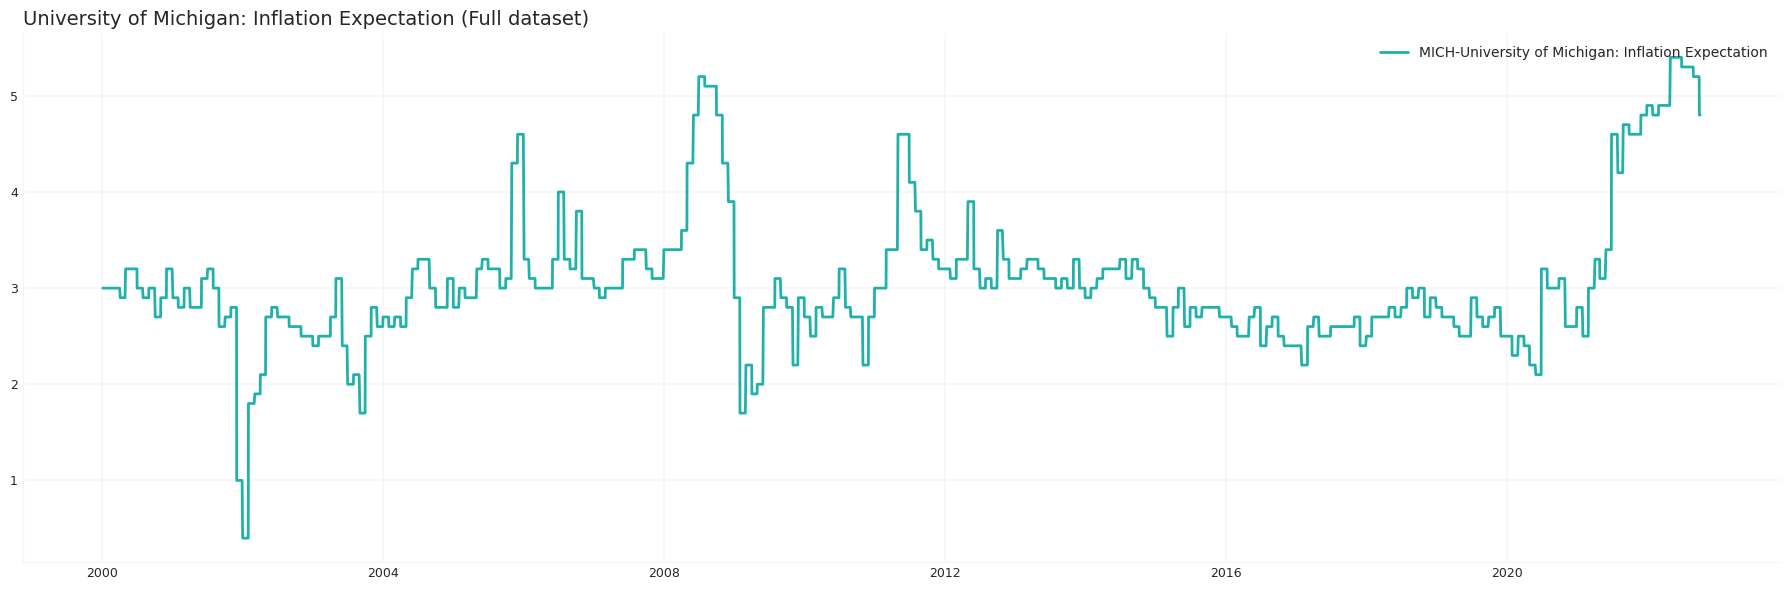

In [27]:
lines(df[['MICH', ]], figsize=(18, 6), caption='University of Michigan: Inflation Expectation (Full dataset)', 
      labels=['MICH-University of Michigan: Inflation Expectation'])

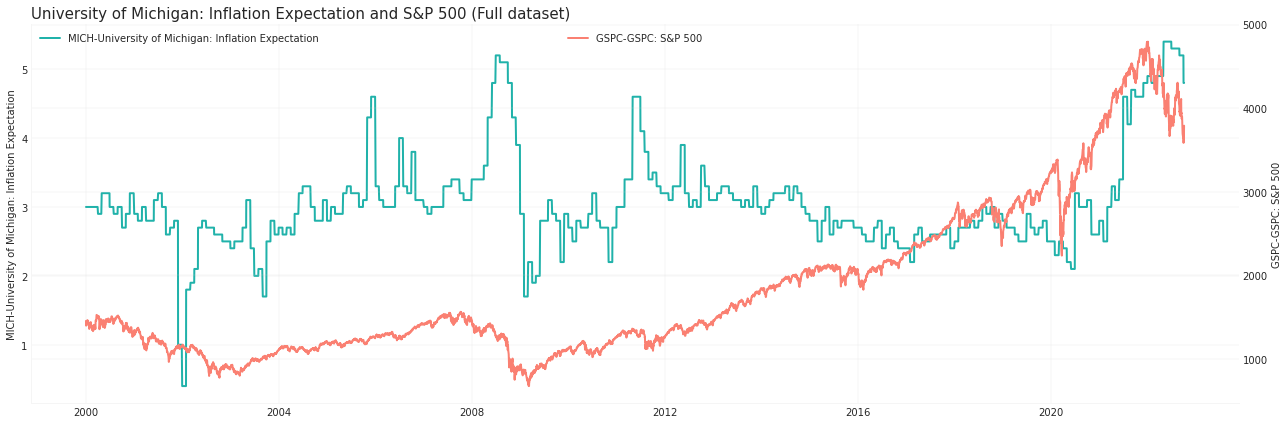

In [28]:
_2lines(df[['MICH', 'GSPC']], figsize=(18, 6), caption='University of Michigan: Inflation Expectation and S&P 500 (Full dataset)', 
      labels=['MICH-University of Michigan: Inflation Expectation', 'GSPC-GSPC: S&P 500'])

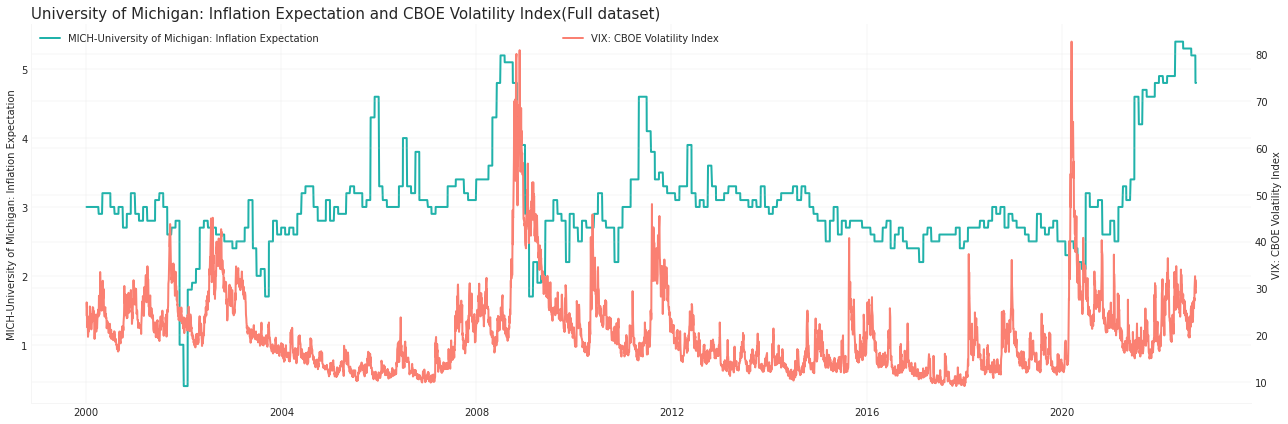

In [29]:
_2lines(df[['MICH', 'VIX']], figsize=(18, 6), caption='University of Michigan: Inflation Expectation and CBOE Volatility Index(Full dataset)', 
      labels=['MICH-University of Michigan: Inflation Expectation',  'VIX: CBOE Volatility Index'])

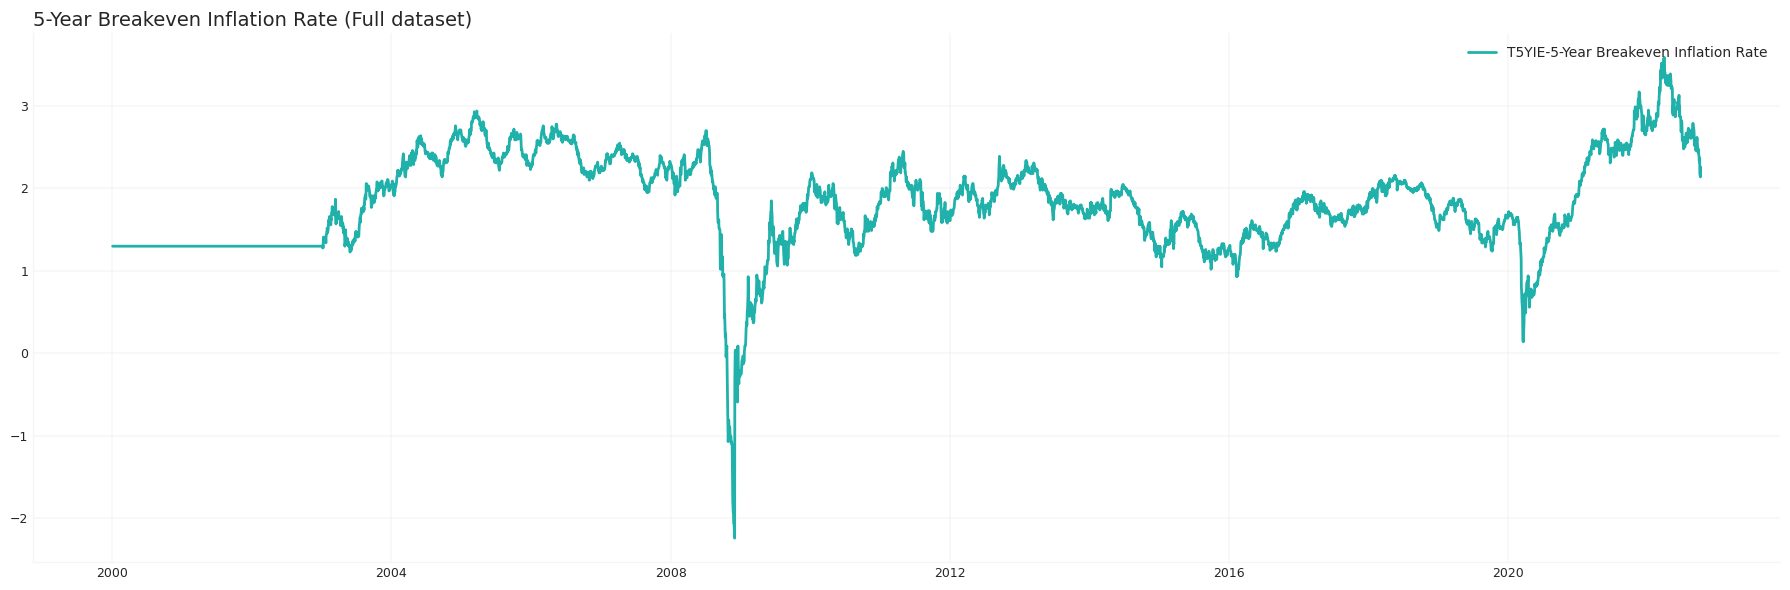

In [30]:
lines(df[['T5YIE', ]], figsize=(18, 6), caption='5-Year Breakeven Inflation Rate (Full dataset)', 
      labels=['T5YIE-5-Year Breakeven Inflation Rate'])

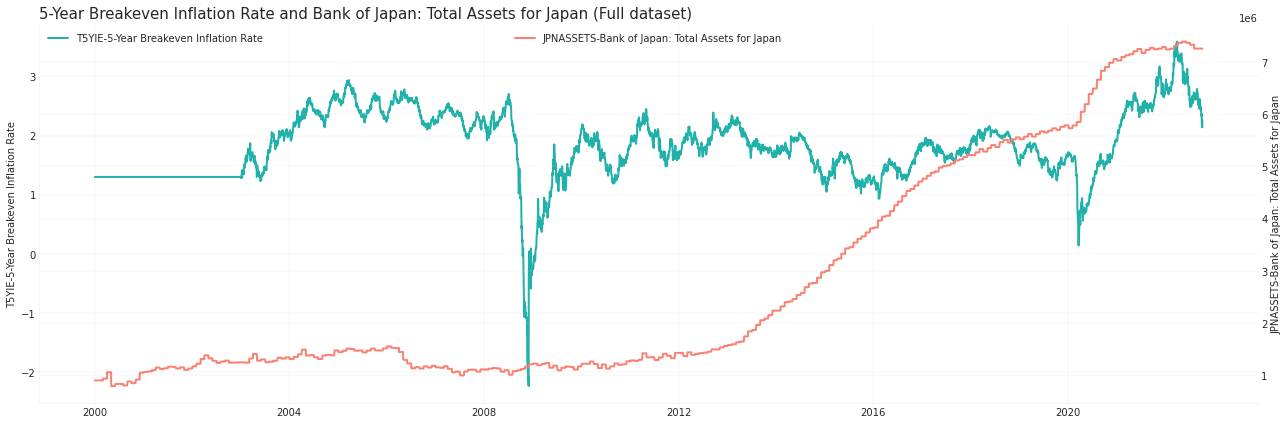

In [31]:
_2lines(df[['T5YIE', 'JPNASSETS']], figsize=(18, 6), caption='5-Year Breakeven Inflation Rate and Bank of Japan: Total Assets for Japan (Full dataset)', 
      labels=['T5YIE-5-Year Breakeven Inflation Rate', 'JPNASSETS-Bank of Japan: Total Assets for Japan'])

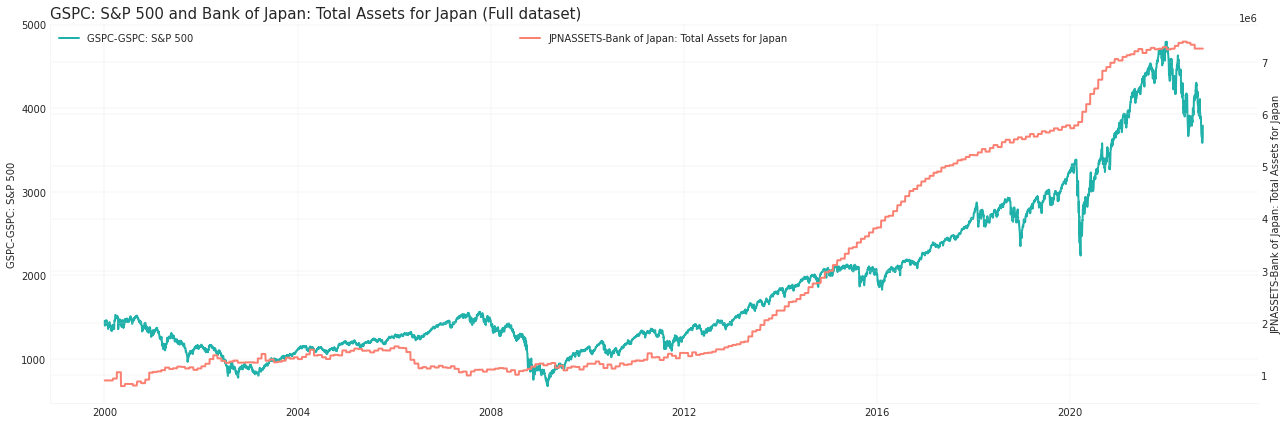

In [32]:
_2lines(df[['GSPC', 'JPNASSETS']], figsize=(18, 6), caption='GSPC: S&P 500 and Bank of Japan: Total Assets for Japan (Full dataset)', 
      labels=['GSPC-GSPC: S&P 500', 'JPNASSETS-Bank of Japan: Total Assets for Japan'])

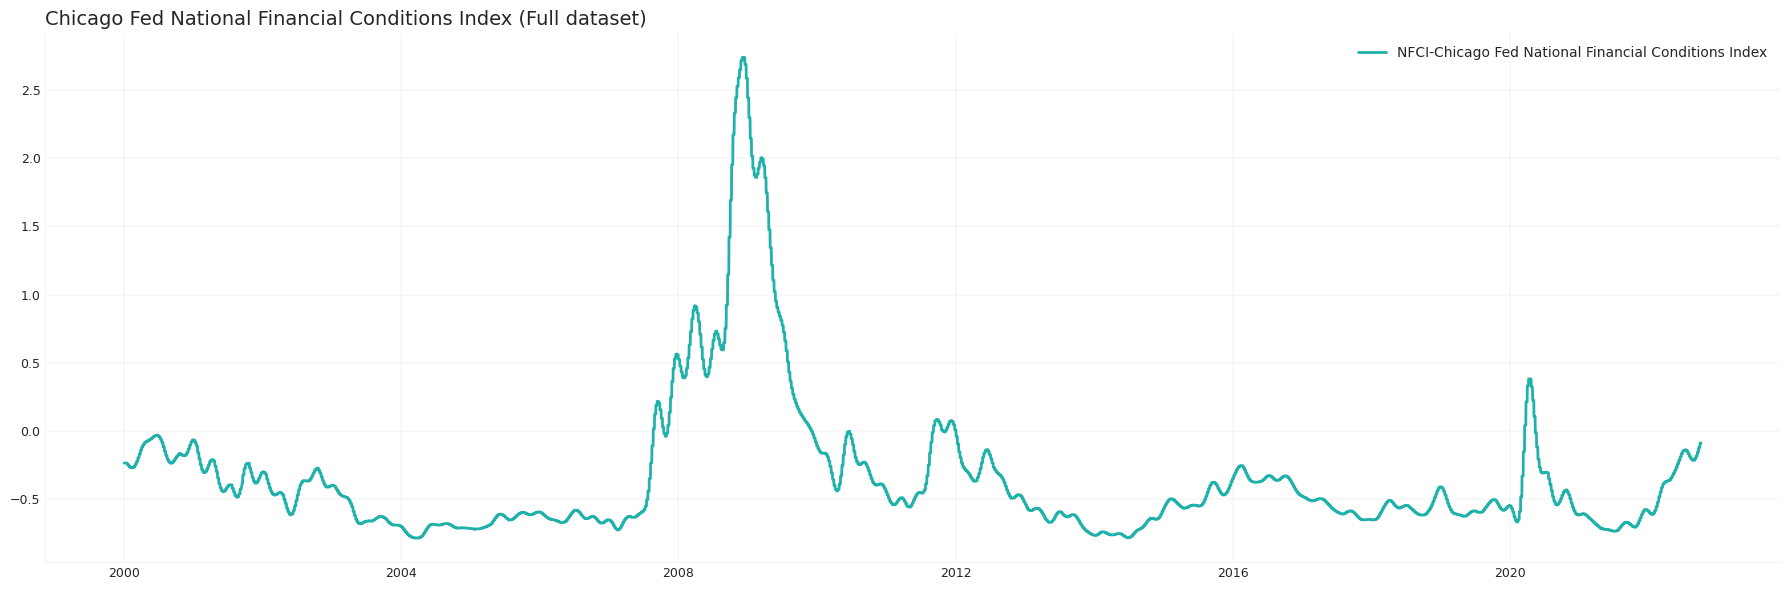

In [33]:
lines(df[['NFCI', ]], figsize=(18, 6), caption='Chicago Fed National Financial Conditions Index (Full dataset)', 
      labels=['NFCI-Chicago Fed National Financial Conditions Index'])

<a id="5"></a>

# <left>5. Input Features - Engineered Features</left>

[back to top](#toc)

For Engineered Features, we look at 3 categories:

- zscore
- pct_change and change
- volatility


|raw feature|raw description| engineered feature| engineered feature description|
|---|---|---|---|
|^N100|Euronext 100 Index|N100_zscore120|rolling 120-day zscore of N100|
|^TNX |CBOE Interest Rate 10 Year T No|TNX_chg20|rolling 20day change (sometimes called momentum) of TNX|
|^FVX |Treasury Yield 5 Years| FVX_pct_chg5|rolling 5-day percent change of FVX|
|OVXCLS | CBOE Crude Oil ETF Volatility Index|OVXCLS_volat60|rolling 60day volatility|

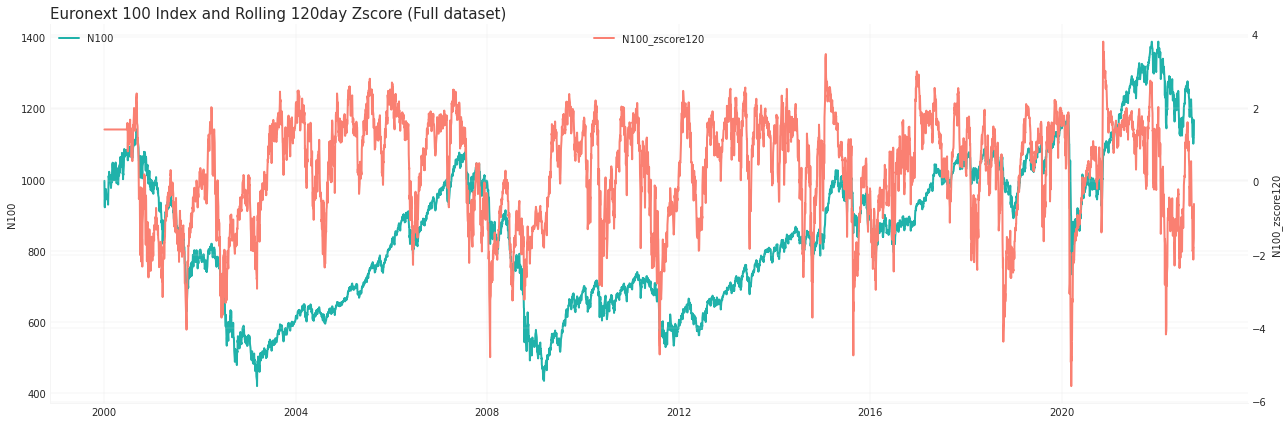

In [34]:
_2lines(df[['N100', 'N100_zscore120']], figsize=(18, 6), caption='Euronext 100 Index and Rolling 120day Zscore (Full dataset)', 
      labels=['N100', 'N100_zscore120'])

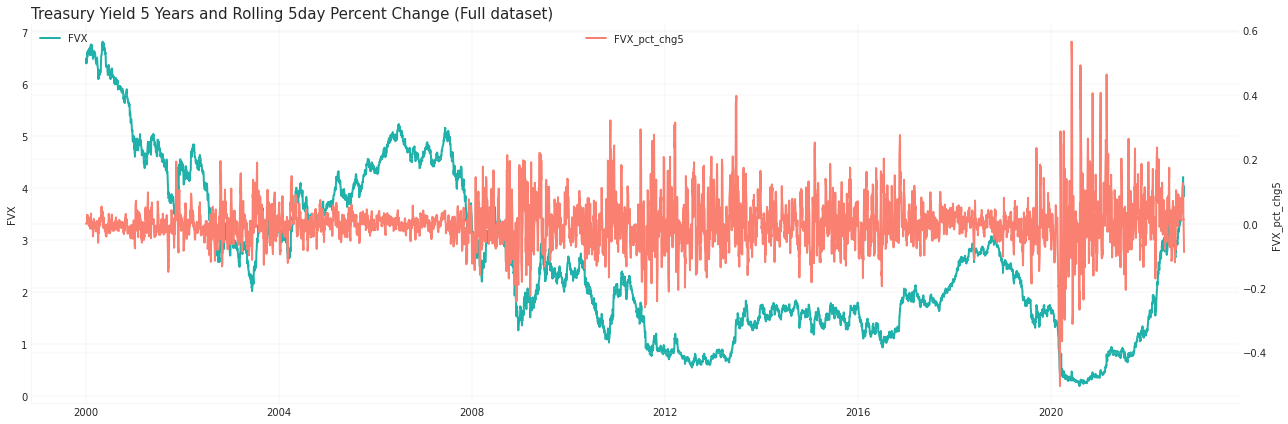

In [35]:
_2lines(df[['FVX', 'FVX_pct_chg5']], figsize=(18, 6), caption='Treasury Yield 5 Years and Rolling 5day Percent Change (Full dataset)', 
      labels=['FVX', 'FVX_pct_chg5'])

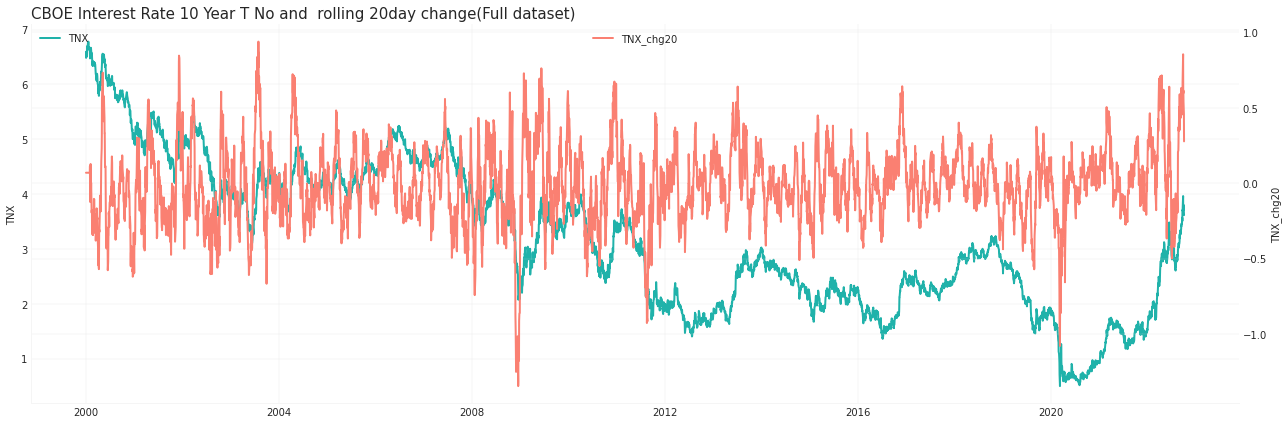

In [36]:
_2lines(df[['TNX', 'TNX_chg20']], figsize=(18, 6), caption='CBOE Interest Rate 10 Year T No and  rolling 20day change(Full dataset)', 
      labels=['TNX', 'TNX_chg20'])

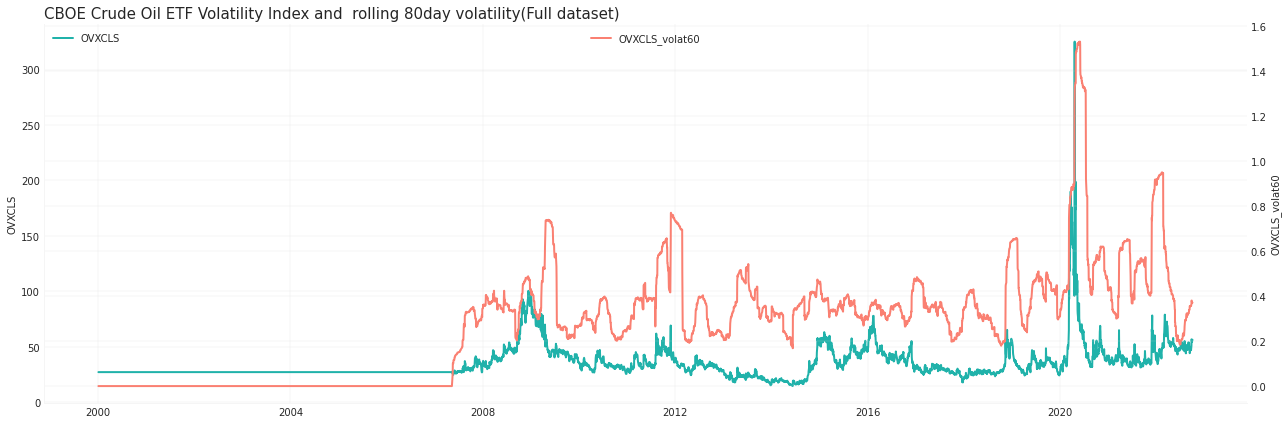

In [37]:
_2lines(df[['OVXCLS', 'OVXCLS_volat60']], figsize=(18, 6), caption='CBOE Crude Oil ETF Volatility Index and  rolling 80day volatility(Full dataset)', 
      labels=['OVXCLS', 'OVXCLS_volat60'])

<a id="6"></a>

# <left>6. Input Features Correlation Matrix</left>

[back to top](#toc)

In [38]:
final_feats = ['NASDAQ100_std125_chg200', 'MICH_ma_dist20_50', 'STLPPM_ma_dist20_50', 'GC=F_chg5', 'STLFSI3_pct_chg5', 'VIXCLS_chg20', 'VIX_zscore250', 'IRLTLT01JPM156N_std125', 'LFWA64TTJPM647S_volat60', 'WILLLRGCAPVAL_std60_chg200', 'GC=F_pct_chg20_above200dMA', 'PAYNSA_zscore200', 'T1YFF_pct_chg20', 'NIKKEI225_zscore120', 'LRUN64TTJPM156S_std125_chg200', 'T1YFF_ma_dist200_50', 'WILLSMLCAP_chg20', 'HSI_chg5', 'JPNASSETS_zscore120', 'NIKKEI225_std60_chg200', 'HSI_chg20', 'N225_pct_chg20', 'FVX_chg5', 'NASDAQ100_pct_chg10', 'RBJPBIS_ma_dist20_50', 'KS11_pct_chg5', 'WILLSMLCAP_chg10', 'T10Y2Y_pct_chg120', 'JTSOSL_std60_chg200', 'BAMLHYH0A0HYM2TRIV_std125_chg200', 'IRLTLT01JPM156N_std60_chg200', 'TB3SMFFM_zscore200', 'NIKKEI225_pct_chg10', 'RBJPBIS_zscore60', 'WILLREITIND_ma_dist20_50', 'LRUN64TTJPM156S_pct_chg250', 'MICH_pct_chg5', 'TNX_mean_std120', 'BAMLHE00EHYITRIV_chg10', 'VXNCLS_mean_std120', 'MYAGM2JPM189S_std125', 'BAA10YM_zscore120', 'T10Y3M_chg250', 'MYAGM2JPM189S_chg20', 'EXPINF1YR_chg5_above200dMA', 'NFCICREDIT_pct_chg60', 'GC=F_pct_chg10', 'REAINTRATREARAT1YE_pct_chg120', 'NDX_chg120', 'GVZCLS_chg5', 'KCFSI_chg20', 'AAA10Y_pct_chg5', 'TENEXPCHAINFRISPRE_ma_dist20_50', 'T5YIEM_pct_chg20', 'BAMLHE00EHYITRIV_chg5', 'USSLIND_pct_chg120', 'FVX_pct_chg10', 'T10YIEM_chg60', 'WILLREITIND_pct_chg20', 'BAA10Y_pct_chg10', 'T10YFF_chg10', 'LFWA64TTJPM647S_chg60', 'OVXCLS_volat60', 'RUT_pct_chg10', 'VXNCLS_chg10', 'BAA10Y_zscore250', 'NDX_chg10', 'T10Y2YM_zscore250', 'JPNASSETS', 'CPFF_pct_chg10', 'WILLREITIND_chg20', 'TNX_chg20', 'IRSTCI01JPM156N_chg20', 'GC=F_zscore60', 'CPFF_pct_chg250', 'CPFF_chg5', 'BAMLHYH0A3CMTRIV_chg10', 'CPFF_pct_chg5', 'VXNCLS_chg5', 'GC=F_chg20', 'FVX_pct_chg5', 'T10Y2Y_pct_chg250', 'FTSE_chg10', 'N100_std60_chg200', 'HSI_zscore60', 'NFCIRISK_pct_chg60', 'STLFSI3_pct_chg60', 'VIX_pct_chg10', 'RVXCLS_chg10', 'NFCICREDIT_pct_chg5', 'STLPPM_chg5', 'T3MFF_zscore60', 'ABCOMP_chg5', 'T10Y3M_pct_chg250', 'ABCOMP_pct_chg5', 'USSLIND_pct_chg20', 'STLPPM_pct_chg5', 'T3MFF_chg10', 'FVX_zscore200', 'VXDCLS_chg5', 'VIX_zscore60', 'VIX_chg20', 'STOXX50E_pct_chg10', 'DJI_zscore120', 'STLFSI3_chg5', 'NFCICREDIT', 'T10YIEM_pct_chg60', 'NDX_zscore60', 'HSI_chg10', 'AAAFF_pct_chg5', 'FTSE_mean_std120', 'MYAGM2JPM189S_chg5', 'BAMLHE00EHYITRIV_pct_chg250', 'REAINTRATREARAT1MO_ma_dist500_250', 'CPFF_pct_chg20', 'VXDCLS_pct_chg10', 'BAMLHYH0A3CMTRIV_zscore120', 'NFCI_chg5', 'FTSE_chg20', 'FVX_ma_dist20_50', 'T10YFF_pct_chg20', 'NFCILEVERAGE_chg250', 'BAMLHYH0A0HYM2TRIV_pct_chg10', 'T10Y2YM_std125_chg200', 'CFNAIDIFF_std60', 'N100_zscore120', 'DJI_chg10']


In [39]:
all_corr = train_df[final_feats+['target']].corr()

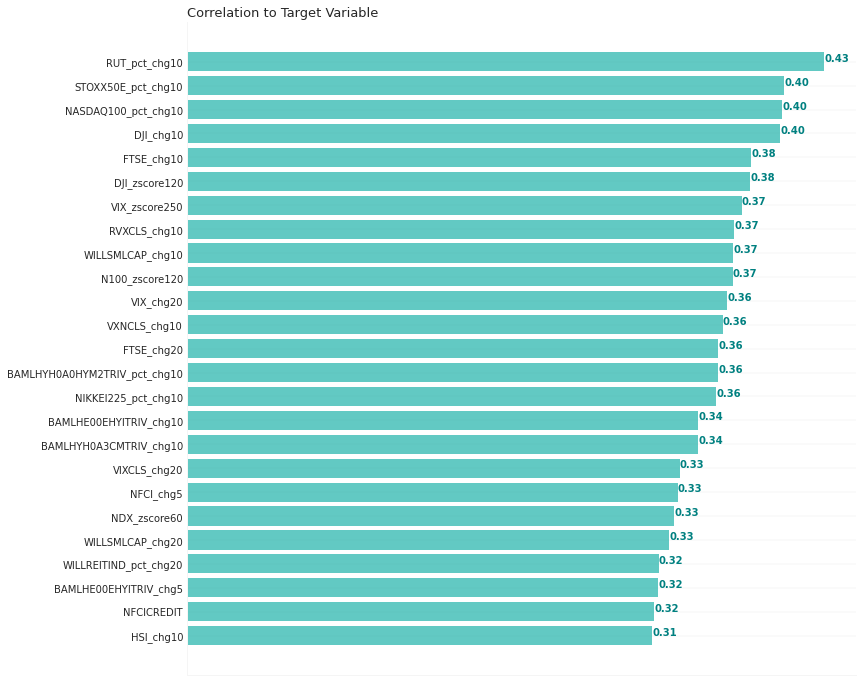

In [40]:
y_corr2=all_corr['target']
y_corr2.name='corr'
df_corr2 = y_corr2.to_frame()
df_corr2['abs_corr'] = df_corr2['corr'].abs()
df_corr2.sort_values(by='abs_corr', ascending=False, inplace=True)
bar(df_corr2['abs_corr'].iloc[1:26][::-1], 'Correlation to Target Variable', figsize=(12, 12))

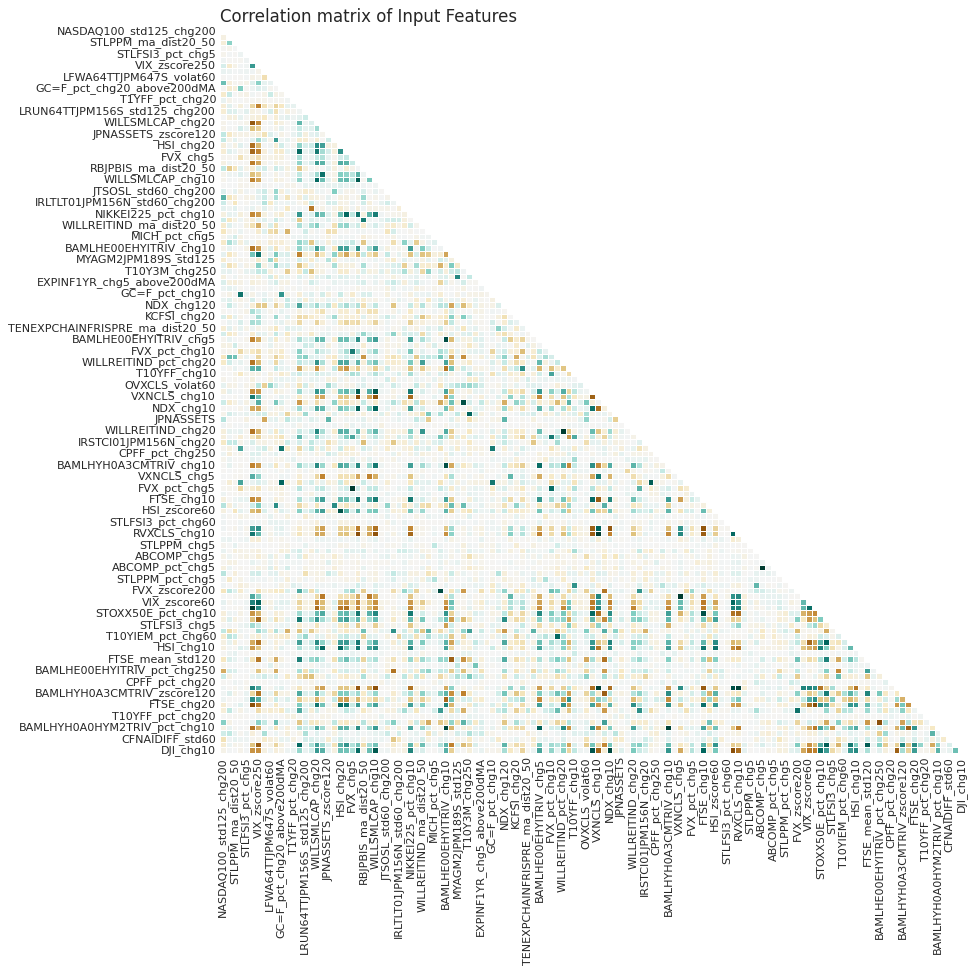

In [41]:
plot_corr(all_corr.loc[final_feats, final_feats], figsize=(12, 12), caption='Correlation matrix of Input Features', x_bottom=True)